In [12]:
import numpy as np, tifffile as tiff, matplotlib.pyplot as plt
import SimpleITK as sitk
from skimage.filters import threshold_otsu, sobel


from typing import Tuple

def clip_and_scale(
    v: np.ndarray, pcts: Tuple[float, float] = (0.5, 99.5), eps: float = 1e-6
) -> Tuple[np.ndarray, float, float]:
    p1, p2 = np.percentile(v, pcts)
    if not np.isfinite(p1) or not np.isfinite(p2):
        raise ValueError("Percentiles are NaN/Inf")
    if p2 <= p1:
        scaled = np.zeros_like(v, dtype=np.float32)
        return scaled, float(p1), float(p2)
    clipped = np.clip(v, p1, p2)
    scaled = ((clipped - p1) / (p2 - p1 + eps)).astype(np.float32, copy=False)
    np.clip(scaled, 0.0, 1.0, out=scaled)
    return scaled, float(p1), float(p2)

def n4_bias_correction_sitk(volume: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Return (bias_field, corrected) as float32 arrays."""
    v = volume.astype(np.float32)
    t = threshold_otsu(v)
    sample_mask = v > t
    img = sitk.GetImageFromArray(v)
    msk = sitk.GetImageFromArray(sample_mask.astype(np.uint8))
    
    shrinkFactor = 4
    image = sitk.Shrink(img, [shrinkFactor]*img.GetDimension())
    mask_image = sitk.Shrink(msk, [shrinkFactor]*img.GetDimension())
    
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrector.SetMaximumNumberOfIterations([50, 50, 50, 50])
    corrected_image = corrector.Execute(image, mask_image)
    log_bias_field = corrector.GetLogBiasFieldAsImage(image)
    corrected = sitk.GetArrayFromImage(corrected_image).astype(np.float32)
    bias_field = np.exp(sitk.GetArrayFromImage(log_bias_field)).astype(np.float32)
    return bias_field, corrected


shape: (250, 700, 700) dtype: float32


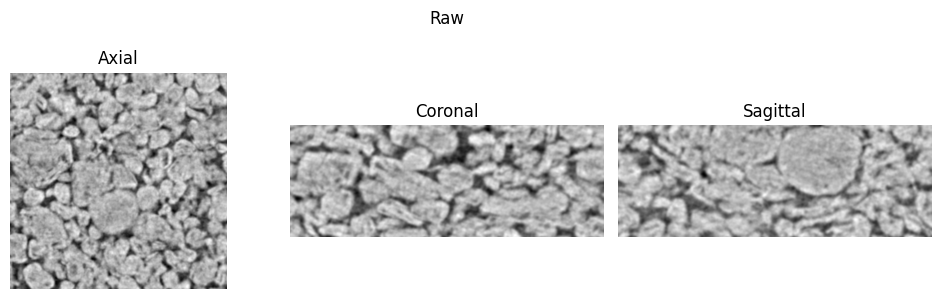

In [13]:
vol = tiff.imread("../data/Litarion.tif").astype(np.float32)
print("shape:", vol.shape, "dtype:", vol.dtype)

# show mid-slices
def show3(v: np.ndarray, title=""):
    z, y, x = v.shape
    fig, axs = plt.subplots(1,3, figsize=(10,3))
    axs[0].imshow(v[z//2], cmap="gray"); axs[0].set_title("Axial")
    axs[1].imshow(v[:,y//2,:], cmap="gray"); axs[1].set_title("Coronal")
    axs[2].imshow(v[:,:,x//2], cmap="gray"); axs[2].set_title("Sagittal")
    for a in axs: a.axis("off")
    fig.suptitle(title); plt.tight_layout(); plt.show()

show3(vol, "Raw")


clip_and_scale pre-N4: p1=-0.000, p2=0.000


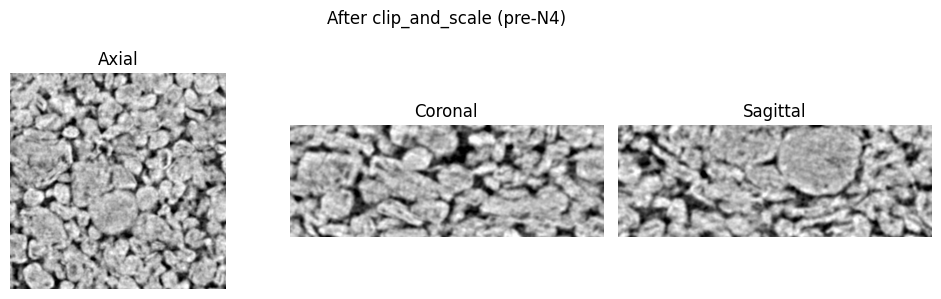

In [8]:
scaled0, p1a, p2a = clip_and_scale(vol, (0.5, 99.5))
print(f"clip_and_scale pre-N4: p1={p1a:.3f}, p2={p2a:.3f}")
show3(scaled0, "After clip_and_scale (pre-N4)")

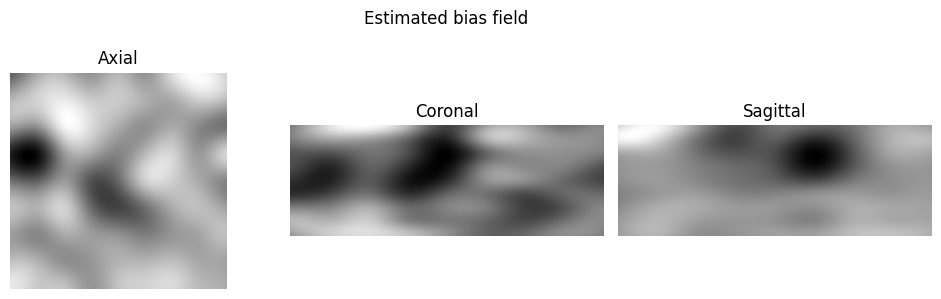

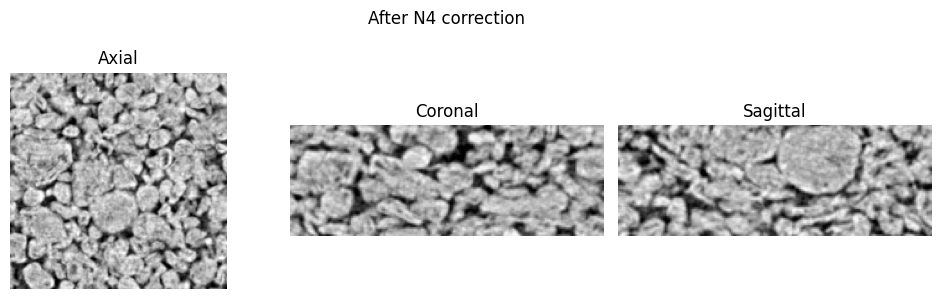

clip_and_scale post-N4: p1=0.000, p2=0.750


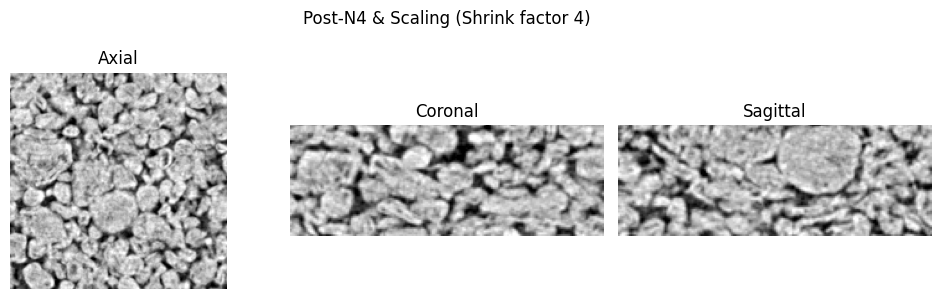

In [10]:


bias, corr = n4_bias_correction_sitk(scaled0)   # N4 on scaled data
show3(bias, "Estimated bias field")
show3(corr, "After N4 correction")

# final standardisation
scaled1, p1b, p2b = clip_and_scale(corr, (0.5, 99.5))
print(f"clip_and_scale post-N4: p1={p1b:.3f}, p2={p2b:.3f}")
show3(scaled1, "Post-N4 & Scaling (Shrink factor 4)")

In [14]:
from typing import Tuple
from skimage.filters import threshold_otsu
from skimage.restoration import denoise_tv_chambolle
from typing import Optional
import SimpleITK as sitk
import numpy as np


def clip_and_scale(
    v: np.ndarray, pcts: Tuple[float, float] = (0.5, 99.5), eps: float = 1e-6
) -> Tuple[np.ndarray, float, float]:
    """Clip and scale a value to the range [0, 1] based on given percentiles.

    Args:
        v: The input value or array to be clipped and scaled.
        pcts: A tuple containing the lower and upper percentiles for clipping.
        eps: A small epsilon value to prevent division by zero.

    Returns:
        A list containing the clipped and scaled array,
        the lower percentile value, and the upper percentile value.
    """
    p1, p2 = np.percentile(v, pcts)

    if not np.isfinite(p1) or not np.isfinite(p2):
        raise ValueError("Percentiles are NaN/Inf")

    if p2 <= p1:
        scaled = np.zeros_like(v, dtype=np.float32)
        return scaled, float(p1), float(p2)
    else:
        clipped: np.ndarray = np.clip(v, p1, p2)
        scaled_v: np.ndarray = (clipped - p1) / (p2 - p1 + eps)
        scaled = scaled_v.astype(np.float32, copy=False)

    np.clip(scaled, 0.0, 1.0, out=scaled)
    return scaled, float(p1), float(p2)

def denoise_tv(volume: np.ndarray, weight: float=0.05, n_iter_max: int = 200, mask: Optional[np.ndarray] = None):
    v = volume.astype(np.float32, copy=False)
    
    if mask is None:
        out = denoise_tv_chambolle(
            v,
            weight=weight,
            max_num_iter=n_iter_max,
            channel_axis=None,
        ).astype(np.float32, copy=False)
    else:
        den = denoise_tv_chambolle(
            v,
            weight=weight,
            max_num_iter=n_iter_max,
            channel_axis=None
        ).astype(np.float32, copy=False)
        out = v.copy()
        out[mask.astype(bool)] = den[mask.astype(bool)]
    
    np.clip(out, 0.0, 1.0, out=out)
    return out


Scaled to [0,1] using percentiles: -2.22e-06-1.62e-06
min, max, unique= -3.4975624e-06 2.668628e-06 [-3.4975624e-06 -3.4753218e-06 -3.4709017e-06 ...  2.6369062e-06
  2.6478174e-06  2.6686280e-06]


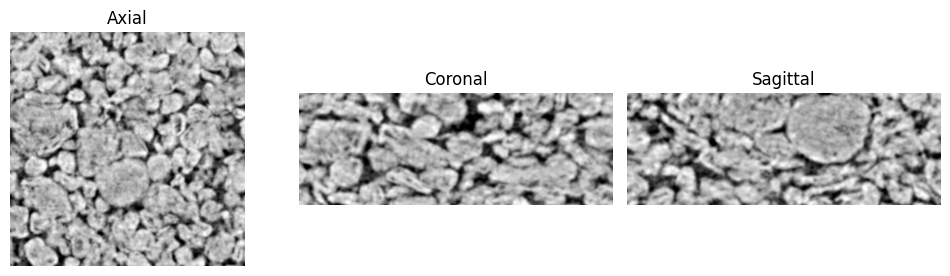

In [15]:
from tifffile import imread
v_raw = imread("../data/Litarion.tif")
v_scaled, p1, p2 = clip_and_scale(v_raw, pcts=(0.5, 99.5))

print(f"Scaled to [0,1] using percentiles: {p1:.2e}-{p2:.2e}")
print("min, max, unique=", np.min(v_raw), np.max(v_raw), np.unique(v_raw))

specimen_mask = v_scaled > v_scaled.mean()
tv_denoised = denoise_tv(v_scaled, weight=0.05, n_iter_max=200, mask=specimen_mask)

show3(tv_denoised)


In [17]:
# NLM
import numpy as np
from skimage.restoration import denoise_nl_means, estimate_sigma

def nlm3d(volume: np.ndarray, patch_size=3, patch_distance=6, k=0.9, fast=True):
    v = volume.astype(np.float32, copy=False)
    sigma = float(estimate_sigma(v, channel_axis=None))
    h = max(1e-6, k*sigma)
    out = denoise_nl_means(
        v,
        h=h,
        patch_size=patch_size,
        patch_distance=patch_distance,
        fast_mode=fast,
        channel_axis=None,
        preserve_range=True
    ).astype(np.float32, copy=False)
    return out, h, sigma

In [ ]:
from tifffile import imread
v_raw = imread("../data/Litarion.tif")
v_scaled, p1, p2 = clip_and_scale(v_raw, pcts=(0.5, 99.5))

print(f"Scaled to [0,1] using percentiles: {p1:.2e}-{p2:.2e}")
print("min, max, unique=", np.min(v_raw), np.max(v_raw), np.unique(v_raw))

out, h, sigma = nlm3d(v_scaled)

show3(out)


Scaled to [0,1] using percentiles: -2.22e-06-1.62e-06
min, max, unique= -3.4975624e-06 2.668628e-06 [-3.4975624e-06 -3.4753218e-06 -3.4709017e-06 ...  2.6369062e-06
  2.6478174e-06  2.6686280e-06]
